套件匯入完成。

--- 步驟 1: 載入資料 ---
k04.csv 檔案載入成功。

--- 步驟 2: 資料清理與目標變數轉換 ---
原始資料共 5013 筆。
經過清理（移除缺失與異常騎乘時間）後，剩下 4962 筆有效資料。

--- 步驟 3: 特徵工程 ---
已從日期時間中提取出 'Hour', 'DayOfWeek', 'Month' 特徵。
已對站點 'Stp1' 進行清理與 One-Hot Encoding。

--- 步驟 4: 準備模型輸入資料 ---
最終使用的特徵欄位:
['Hour', 'DayOfWeek', 'Month', 'Stp_Stp1_Exit1', 'Stp_Stp1_Exit2']
資料集準備完成，共 4962 筆資料。

--- 步驟 5: 模型訓練與評估 ---
訓練集大小: 3969 筆, 測試集大小: 993 筆
開始訓練隨機森林模型...
模型訓練完成！

模型評估結果：
平均絕對誤差 (MAE): 205.25 秒 (代表模型預測的平均誤差約為 3.42 分鐘)
R-squared (R²): -0.12 (此數值越接近1，代表模型解釋力越強)

--- 步驟 6: 模型解釋 ---

各特徵對預測的貢獻度排名：
          feature  importance
0            Hour    0.346661
1       DayOfWeek    0.303153
2           Month    0.297808
4  Stp_Stp1_Exit2    0.026535
3  Stp_Stp1_Exit1    0.025843


C:\Users\user\AppData\Local\Temp\ipykernel_6076\42046762.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')



正在顯示視覺化圖表...


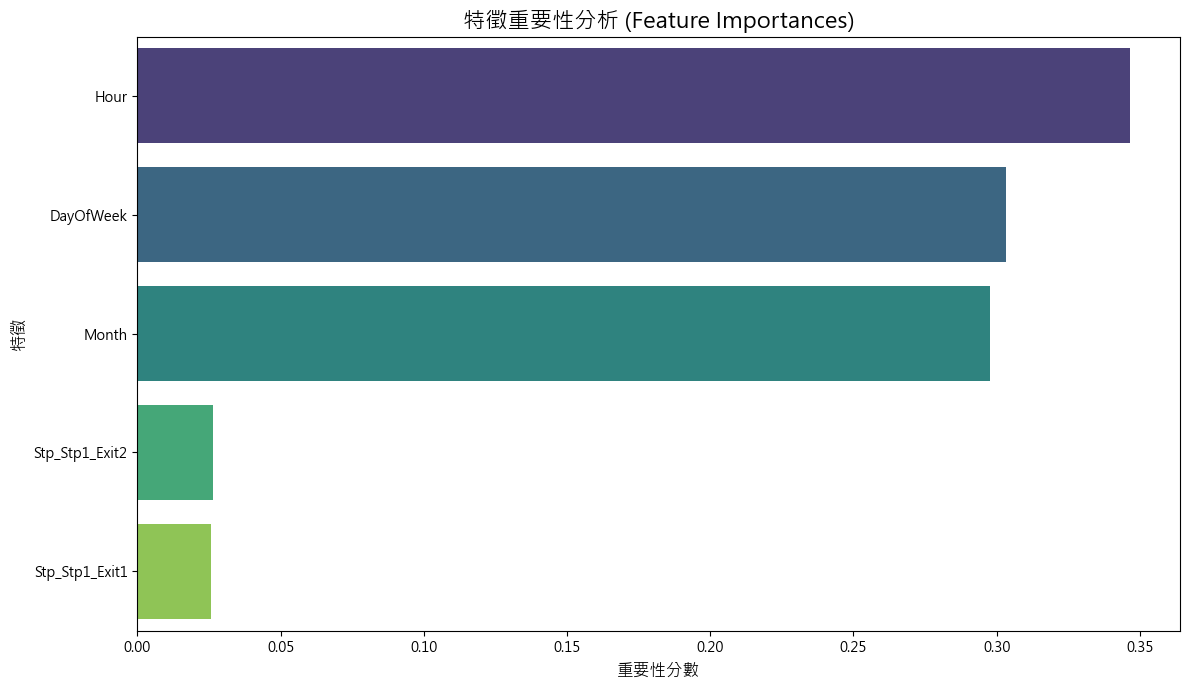

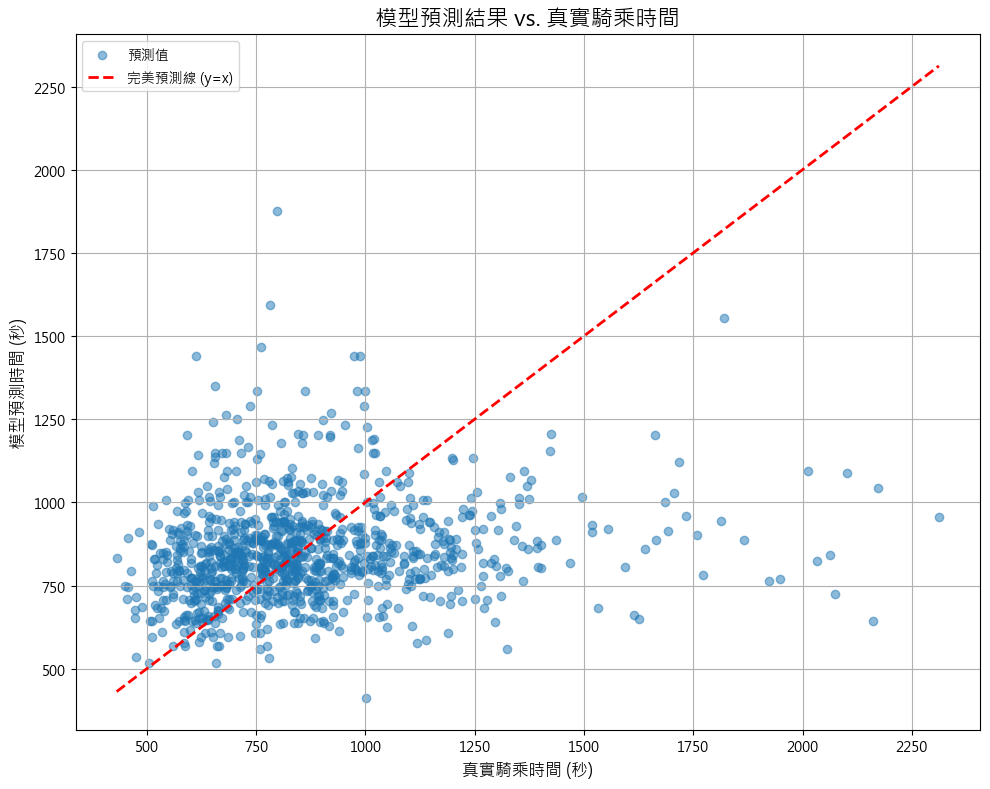


--- 步驟 7: 實際應用範例 ---

情境：星期五早上 8 點，從芝山站 2 號出口出發
模型預測的騎乘時間為：約 13 分 30 秒


In [1]:
# -------------------------------------------------------------------
# 步驟 0: 匯入所有必要的套件
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("套件匯入完成。")

# -------------------------------------------------------------------
# 全域設定：設定 Matplotlib 以支援繁體中文顯示
# -------------------------------------------------------------------
# 確保圖表可以顯示中文（Windows: Microsoft JhengHei, Mac: PingFang TC）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
# 解決座標軸負號顯示問題
plt.rcParams['axes.unicode_minus'] = False


# -------------------------------------------------------------------
# 步驟 1: 載入與檢視資料
# -------------------------------------------------------------------
print("\n--- 步驟 1: 載入資料 ---")
try:
    # 使用 'utf-8-sig' 來處理可能存在的 BOM (位元組順序標記)
    df_raw = pd.read_csv('k04.csv', encoding='utf-8-sig')
    # 刪除因為 CSV 格式問題可能產生的空欄位
    df_raw = df_raw.loc[:, ~df_raw.columns.str.contains('^Unnamed')]
    print("k04.csv 檔案載入成功。")
    # print("資料前五筆：")
    # print(df_raw.head())
except FileNotFoundError:
    print("錯誤：找不到 'k04.csv' 檔案。請確保檔案與程式碼在同一個目錄下。")
    exit()

# -------------------------------------------------------------------
# 步驟 2: 資料清理與目標變數轉換 (騎乘時間)
# -------------------------------------------------------------------
print("\n--- 步驟 2: 資料清理與目標變數轉換 ---")

# 複製一份資料進行處理，以保留原始資料
df = df_raw.copy()

# 定義一個函式，將 MM:SS 格式的字串轉換為總秒數
def time_to_seconds(time_str):
    try:
        parts = str(time_str).split(':')
        minutes = int(parts[0])
        seconds = int(parts[1])
        return minutes * 60 + seconds
    except (ValueError, TypeError, IndexError):
        return np.nan # 如果格式錯誤或為空，則返回 NaN

# 應用函式，創建新欄位 'TotalSeconds'
df['TotalSeconds'] = df['Time2'].apply(time_to_seconds)

# 清理資料
original_rows = len(df)
# 移除 'TotalSeconds' 為 NaN 的資料
df.dropna(subset=['TotalSeconds'], inplace=True)
# 移除騎乘時間 > 40 分鐘 (2400 秒) 的異常值
df = df[df['TotalSeconds'] <= 2400]
cleaned_rows = len(df)

print(f"原始資料共 {original_rows} 筆。")
print(f"經過清理（移除缺失與異常騎乘時間）後，剩下 {cleaned_rows} 筆有效資料。")


# -------------------------------------------------------------------
# 步驟 3: 特徵工程 (Feature Engineering)
# -------------------------------------------------------------------
print("\n--- 步驟 3: 特徵工程 ---")

# 1. 處理時間相關特徵
# 將 'Date' 和 'Time1' 合併成一個標準的 datetime 物件
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time1'])

# 根據 'AM/PM' 欄位校正小時（處理12小時制）
# 條件1: 如果是 PM 且小時 < 12 (例如 01:00 PM)，則加 12 小時
df.loc[(df['AM/PM'] == 'PM') & (df['DateTime'].dt.hour < 12), 'DateTime'] += pd.Timedelta(hours=12)
# 條件2: 如果是 AM 且小時為 12 (12:00 AM，即午夜)，則減 12 小時使其變為 0 點
df.loc[(df['AM/PM'] == 'AM') & (df['DateTime'].dt.hour == 12), 'DateTime'] -= pd.Timedelta(hours=12)

# 從校正後的 'DateTime' 提取有用的數值特徵
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # 0=週一, 1=週二, ..., 6=週日
df['Month'] = df['DateTime'].dt.month
print("已從日期時間中提取出 'Hour', 'DayOfWeek', 'Month' 特徵。")

# 2. 處理站點類別特徵
# 清理並標準化 'Stp1' 站點名稱
def clean_station_name(name):
    if '1號出口' in str(name):
        return 'Stp1_Exit1'
    elif '2號出口' in str(name):
        return 'Stp1_Exit2'
    else:
        # 如果沒有明確標示出口，根據資料觀察，預設為2號出口
        return 'Stp1_Exit2'

df['Stp_Cleaned'] = df['Stp1'].apply(clean_station_name)

# 使用 One-Hot Encoding 將類別特徵轉換為數值
df = pd.get_dummies(df, columns=['Stp_Cleaned'], prefix='Stp', drop_first=False)
print("已對站點 'Stp1' 進行清理與 One-Hot Encoding。")


# -------------------------------------------------------------------
# 步驟 4: 準備模型輸入 (特徵矩陣 X 和目標向量 y)
# -------------------------------------------------------------------
print("\n--- 步驟 4: 準備模型輸入資料 ---")

# 選擇最終要用來訓練的特徵欄位
feature_columns = ['Hour', 'DayOfWeek', 'Month'] + [col for col in df.columns if 'Stp_Stp' in col]
target_column = 'TotalSeconds'

X = df[feature_columns]
y = df[target_column]

print("最終使用的特徵欄位:")
print(X.columns.to_list())
print(f"資料集準備完成，共 {len(X)} 筆資料。")


# -------------------------------------------------------------------
# 步驟 5: 模型訓練與評估
# -------------------------------------------------------------------
print("\n--- 步驟 5: 模型訓練與評估 ---")

# 1. 將資料分割為訓練集 (80%) 和測試集 (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"訓練集大小: {len(X_train)} 筆, 測試集大小: {len(X_test)} 筆")

# 2. 建立並訓練隨機森林模型
# n_estimators: 樹的數量，越多通常越好但會變慢
# n_jobs=-1: 使用所有 CPU 核心來加速
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("開始訓練隨機森林模型...")
rf_model.fit(X_train, y_train)
print("模型訓練完成！")

# 3. 在測試集上進行預測並評估
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n模型評估結果：")
print(f"平均絕對誤差 (MAE): {mae:.2f} 秒 (代表模型預測的平均誤差約為 {mae/60:.2f} 分鐘)")
print(f"R-squared (R²): {r2:.2f} (此數值越接近1，代表模型解釋力越強)")


# -------------------------------------------------------------------
# 步驟 6: 模型解釋 (視覺化)
# -------------------------------------------------------------------
print("\n--- 步驟 6: 模型解釋 ---")

# 1. 特徵重要性分析
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n各特徵對預測的貢獻度排名：")
print(feature_importances)

# 視覺化特徵重要性
plt.figure(figsize=(12, 7))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('特徵重要性分析 (Feature Importances)', fontsize=16)
plt.xlabel('重要性分數', fontsize=12)
plt.ylabel('特徵', fontsize=12)
plt.tight_layout()
# plt.show() # 如果一次只想顯示一張圖，可以取消這行的註解

# 2. 預測結果與真實值比較圖
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5, label='預測值')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='完美預測線 (y=x)')
plt.title('模型預測結果 vs. 真實騎乘時間', fontsize=16)
plt.xlabel('真實騎乘時間 (秒)', fontsize=12)
plt.ylabel('模型預測時間 (秒)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

print("\n正在顯示視覺化圖表...")
plt.show() # 一次性顯示所有圖表

# -------------------------------------------------------------------
# 步驟 7: 實際應用 - 進行一次新預測
# -------------------------------------------------------------------
print("\n--- 步驟 7: 實際應用範例 ---")

# 模擬情境：預測「星期五早上 8 點從 2 號出口」出發的騎乘時間
# DayOfWeek=4 (週五), Hour=8, Month=5 (假設), Stp_Stp1_Exit2=1
new_data_dict = {
    'Hour': [8],
    'DayOfWeek': [4],
    'Month': [5],
    'Stp_Stp1_Exit1': [0], # 因為不是1號出口，所以是0
    'Stp_Stp1_Exit2': [1]  # 因為是2號出口，所以是1
}

# 將字典轉換為 DataFrame，並確保欄位順序與訓練時完全一致
new_data_df = pd.DataFrame(new_data_dict)
new_data_df = new_data_df[X_train.columns] # 這是確保順序正確的關鍵步驟

# 使用訓練好的模型進行預測
predicted_seconds = rf_model.predict(new_data_df)[0]

# 將秒數轉換回更易讀的分鐘和秒
pred_minutes = int(predicted_seconds // 60)
pred_seconds = int(predicted_seconds % 60)

print(f"\n情境：星期五早上 8 點，從芝山站 2 號出口出發")
print(f"模型預測的騎乘時間為：約 {pred_minutes} 分 {pred_seconds} 秒")